In [ ]:
!pip install tensorflow-federated
!pip install tensorflow-datasets

In [ ]:
# Import libraries
import tensorflow as tf
import tensorflow_federated as tff
import numpy as np
import os
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# Define paths
base_path = '/content/drive/MyDrive/BrnTmr/tfrecords'
client_names = ['client_1', 'client_2', 'client_3', 'client_4', 'client_5']
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Image parameters (keep original size)
IMG_HEIGHT = 150
IMG_WIDTH = 168
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
NUM_CLIENTS = 5

## Dataset loading

Parsing the TFRecords

In [3]:
# Modified TFRecord parsing function
def parse_tfrecord(example_proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)

    # Decode and resize to original dimensions
    image = tf.io.decode_jpeg(parsed_features['image'], channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = tf.cast(image, tf.float32)
    return image, parsed_features['label']

Creating and loading the federated data

In [4]:
# Load TFRecord datasets
client_train_datasets = []
client_val_datasets = []
client_test_datasets = []

for client in client_names:
    client_dir = os.path.join(base_path, client)

    # Training dataset
    train_ds = tf.data.TFRecordDataset(os.path.join(client_dir, 'train.tfrecord'))
    train_ds = train_ds.map(parse_tfrecord, num_parallel_calls=AUTOTUNE)
    train_ds = train_ds.shuffle(1000)
    train_ds = train_ds.batch(BATCH_SIZE)
    train_ds = train_ds.prefetch(AUTOTUNE)
    train_ds = train_ds.cache()

    # Validation dataset
    val_ds = tf.data.TFRecordDataset(os.path.join(client_dir, 'val.tfrecord'))
    val_ds = val_ds.map(parse_tfrecord, num_parallel_calls=AUTOTUNE)
    val_ds = val_ds.batch(BATCH_SIZE)
    val_ds = val_ds.prefetch(AUTOTUNE)
    val_ds = val_ds.cache()

    # Test dataset
    test_ds = tf.data.TFRecordDataset(os.path.join(client_dir, 'test.tfrecord'))
    test_ds = test_ds.map(parse_tfrecord, num_parallel_calls=AUTOTUNE)
    test_ds = test_ds.batch(BATCH_SIZE)
    test_ds = test_ds.prefetch(AUTOTUNE)
    test_ds = test_ds.cache()

    client_train_datasets.append(train_ds)
    client_val_datasets.append(val_ds)
    client_test_datasets.append(test_ds)

federated_train_data = client_train_datasets
federated_val_data = client_val_datasets
federated_test_data = client_test_datasets

example_dataset = federated_train_data[0]
input_spec = example_dataset.element_spec

In [5]:
example_dataset

<CacheDataset element_spec=(TensorSpec(shape=(None, 150, 168, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [6]:
input_spec

(TensorSpec(shape=(None, 150, 168, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

## Federated training on custom CNN

Defining the model

In [7]:
def create_cnn_model():
    model = tf.keras.Sequential([
        # Conv Block 1
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu',
                              input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        tf.keras.layers.MaxPooling2D(2),

        # Conv Block 2
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(2),

        # Conv Block 3
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(2),

        # Classification Head
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4, activation='softmax')
    ])

    return model

In [8]:
# Verify the output shape
test_model = create_cnn_model()
test_model.build(input_shape=(None, IMG_HEIGHT, IMG_WIDTH, 3))
print(test_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 168, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 84, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 84, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 42, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 42, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 21, 128)       0

In [9]:
# Update model_fn for TFF
def model_fn():
    keras_model = create_cnn_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=federated_train_data[0].element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

Federated training setup

In [ ]:
training_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=tff.learning.optimizers.build_sgdm(learning_rate=0.001),
    server_optimizer_fn=tff.learning.optimizers.build_sgdm(learning_rate=1.0))

train_state = training_process.initialize()

Defining and implementing the training loop

In [11]:
# Training loop
NUM_ROUNDS = 20
CLIENTS_PER_ROUND = 5

# Initialize metric storage
training_history = {
    'round': [],
    'train_loss': [],
    'train_acc': [],
    'val_acc': []
}

for round_num in range(1, NUM_ROUNDS + 1):
    selected_clients_indices = np.random.choice(len(federated_train_data), CLIENTS_PER_ROUND, replace=False)
    selected_clients_data = [federated_train_data[i] for i in selected_clients_indices]

    result = training_process.next(train_state, selected_clients_data)
    train_state = result.state
    train_metrics = result.metrics

    # Apply transformations
    adjusted_loss = train_metrics['client_work']['train']['loss']
    adjusted_acc = train_metrics['client_work']['train']['sparse_categorical_accuracy']

    training_history['round'].append(round_num)
    training_history['train_loss'].append(adjusted_loss)
    training_history['train_acc'].append(adjusted_acc)

    keras_model = create_cnn_model()
    model_weights = training_process.get_model_weights(train_state)
    keras_model.set_weights(model_weights.non_trainable + model_weights.trainable)

    keras_model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

    val_accs = []
    for i in selected_clients_indices:
        val_loss, val_acc = keras_model.evaluate(federated_val_data[i], verbose=0)
        val_accs.append(val_acc)

    training_history['val_acc'].append(np.mean(val_accs))

    print(f'Round {round_num}')
    print(f'  Loss: {adjusted_loss:.4f}')
    print(f'  Accuracy: {adjusted_acc:.4f}')
    print(f'  Val Accuracy: {training_history["val_acc"][-1]:.4f}')

Round 1
  Loss: 12.0399
  Accuracy: 0.2482
  Val Accuracy: 0.3187
Round 2
  Loss: 11.6067
  Accuracy: 0.2744
  Val Accuracy: 0.3818
Round 3
  Loss: 10.5384
  Accuracy: 0.3382
  Val Accuracy: 0.4306
Round 4
  Loss: 9.8333
  Accuracy: 0.3782
  Val Accuracy: 0.4383
Round 5
  Loss: 8.5996
  Accuracy: 0.4354
  Val Accuracy: 0.5617
Round 6
  Loss: 4.4724
  Accuracy: 0.5452
  Val Accuracy: 0.6871
Round 7
  Loss: 0.9357
  Accuracy: 0.6265
  Val Accuracy: 0.7254
Round 8
  Loss: 0.8101
  Accuracy: 0.6718
  Val Accuracy: 0.7416
Round 9
  Loss: 0.7402
  Accuracy: 0.7060
  Val Accuracy: 0.7713
Round 10
  Loss: 0.6786
  Accuracy: 0.7315
  Val Accuracy: 0.7885
Round 11
  Loss: 0.6419
  Accuracy: 0.7443
  Val Accuracy: 0.8010
Round 12
  Loss: 0.5968
  Accuracy: 0.7645
  Val Accuracy: 0.8029
Round 13
  Loss: 0.5612
  Accuracy: 0.7820
  Val Accuracy: 0.8182
Round 14
  Loss: 0.5312
  Accuracy: 0.7901
  Val Accuracy: 0.8191
Round 15
  Loss: 0.5028
  Accuracy: 0.8030
  Val Accuracy: 0.8354
Round 16
  Loss:

Extracting the final aggregated model

In [12]:
# Get final model
final_model = create_cnn_model()
final_weights = training_process.get_model_weights(train_state)
final_model.set_weights(final_weights.non_trainable + final_weights.trainable)

## Model Evaluation

Client wise and aggregated evaluation of the model

Plotting the client wise and aggregated confusion matrices



Client-Wise and Aggregate Evaluation Results
7/7 [==============================] - 4s 525ms/step

Client 1 (client_1) Evaluation

Classification Report:
              precision    recall  f1-score   support

      glioma     0.7544    0.8600    0.8037        50
  meningioma     0.7647    0.5200    0.6190        50
     notumor     0.9365    0.9833    0.9593        60
   pituitary     0.8667    0.9630    0.9123        54

    accuracy                         0.8411       214
   macro avg     0.8306    0.8316    0.8236       214
weighted avg     0.8362    0.8411    0.8316       214



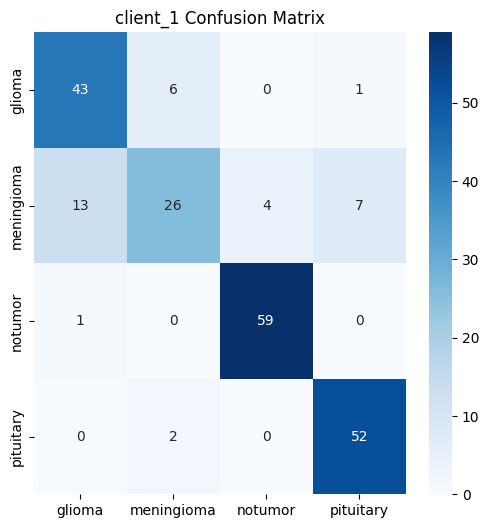

7/7 [==============================] - 5s 708ms/step

Client 2 (client_2) Evaluation

Classification Report:
              precision    recall  f1-score   support

      glioma     0.7963    0.8600    0.8269        50
  meningioma     0.8000    0.6400    0.7111        50
     notumor     0.9219    0.9833    0.9516        60
   pituitary     0.9286    0.9630    0.9455        54

    accuracy                         0.8692       214
   macro avg     0.8617    0.8616    0.8588       214
weighted avg     0.8657    0.8692    0.8647       214



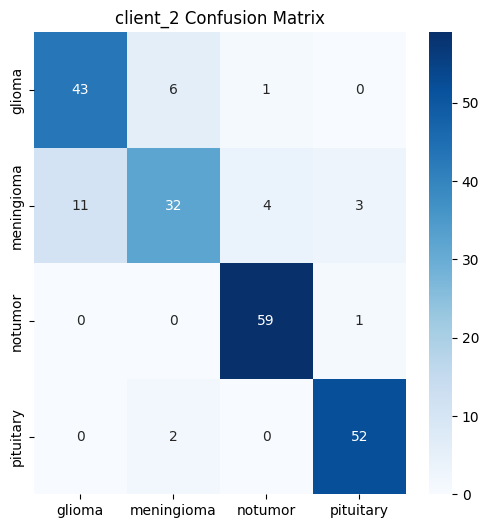

7/7 [==============================] - 3s 455ms/step

Client 3 (client_3) Evaluation

Classification Report:
              precision    recall  f1-score   support

      glioma     0.7966    0.9400    0.8624        50
  meningioma     0.9032    0.5600    0.6914        50
     notumor     0.9077    0.9833    0.9440        60
   pituitary     0.8814    0.9630    0.9204        54

    accuracy                         0.8692       214
   macro avg     0.8722    0.8616    0.8545       214
weighted avg     0.8740    0.8692    0.8599       214



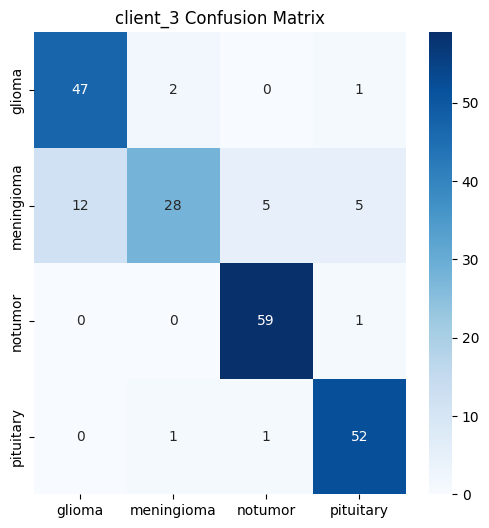

7/7 [==============================] - 3s 458ms/step

Client 4 (client_4) Evaluation

Classification Report:
              precision    recall  f1-score   support

      glioma     0.7800    0.7800    0.7800        50
  meningioma     0.7500    0.6600    0.7021        50
     notumor     0.8889    0.9333    0.9106        60
   pituitary     0.8772    0.9259    0.9009        54

    accuracy                         0.8318       214
   macro avg     0.8240    0.8248    0.8234       214
weighted avg     0.8280    0.8318    0.8289       214



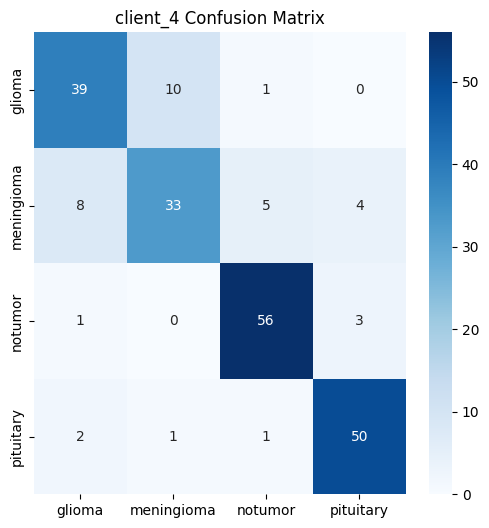

7/7 [==============================] - 5s 693ms/step

Client 5 (client_5) Evaluation

Classification Report:
              precision    recall  f1-score   support

      glioma     0.7963    0.8600    0.8269        50
  meningioma     0.7838    0.5800    0.6667        50
     notumor     0.9062    0.9667    0.9355        60
   pituitary     0.8814    0.9630    0.9204        54

    accuracy                         0.8505       214
   macro avg     0.8419    0.8424    0.8374       214
weighted avg     0.8457    0.8505    0.8435       214



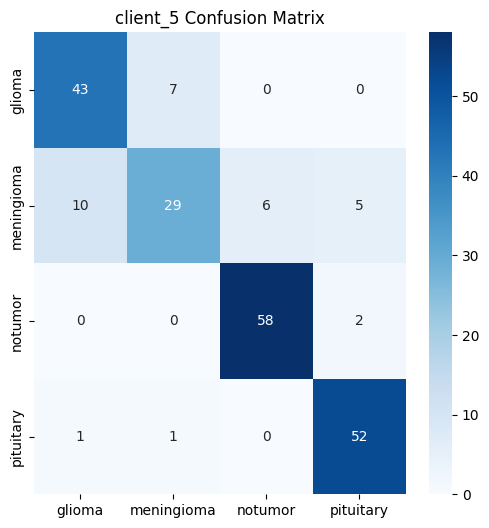


Aggregate Classification Report (All Clients):
              precision    recall  f1-score   support

      glioma     0.7847    0.8600    0.8206       250
  meningioma     0.7957    0.5920    0.6789       250
     notumor     0.9122    0.9700    0.9402       300
   pituitary     0.8866    0.9556    0.9198       270

    accuracy                         0.8523      1070
   macro avg     0.8448    0.8444    0.8399      1070
weighted avg     0.8487    0.8523    0.8461      1070



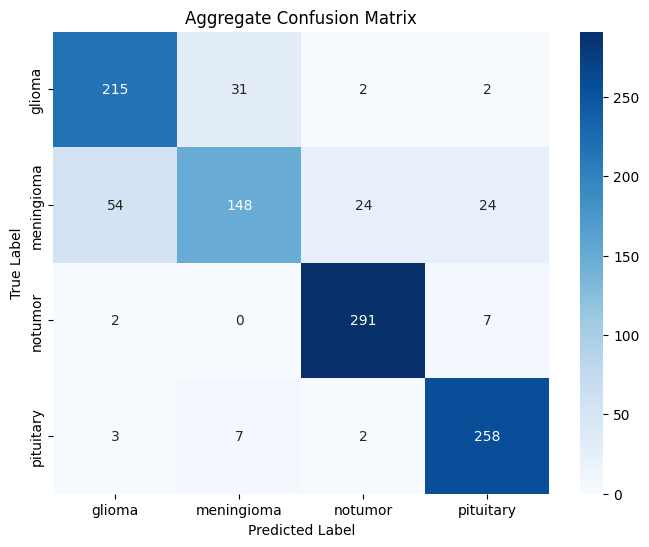

In [24]:
# Complete evaluation
all_y_true = []
all_y_pred = []

# Client wise reporting
print("\n\nClient-Wise and Aggregate Evaluation Results")

for i, (test_data, client) in enumerate(zip(federated_test_data, client_names)):
    # Get predictions once and reuse
    y_true = np.concatenate([y for x, y in test_data], axis=0)
    y_pred = final_model.predict(test_data).argmax(axis=1)

    # Store for aggregate report
    all_y_true.extend(y_true)
    all_y_pred.extend(y_pred)

    # Client-wise reporting
    print(f'\n{"="*50}')
    print(f'Client {i+1} ({client}) Evaluation')
    print('\nClassification Report:')
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # Client confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(confusion_matrix(y_true, y_pred),
                annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{client} Confusion Matrix')
    plt.savefig(f'/content/drive/MyDrive/BrnTmr/{client} cm.png')
    plt.show()

# Aggregate reporting
print("\n" + "="*50)
print("Aggregate Classification Report (All Clients):")
print(classification_report(all_y_true, all_y_pred, target_names=class_names, digits=4))
print("="*50)

# Aggregate confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(all_y_true, all_y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Aggregate Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('/content/drive/MyDrive/BrnTmr/aggregate cm.png')
plt.show()

Plotting the round wise accuracies and the loss

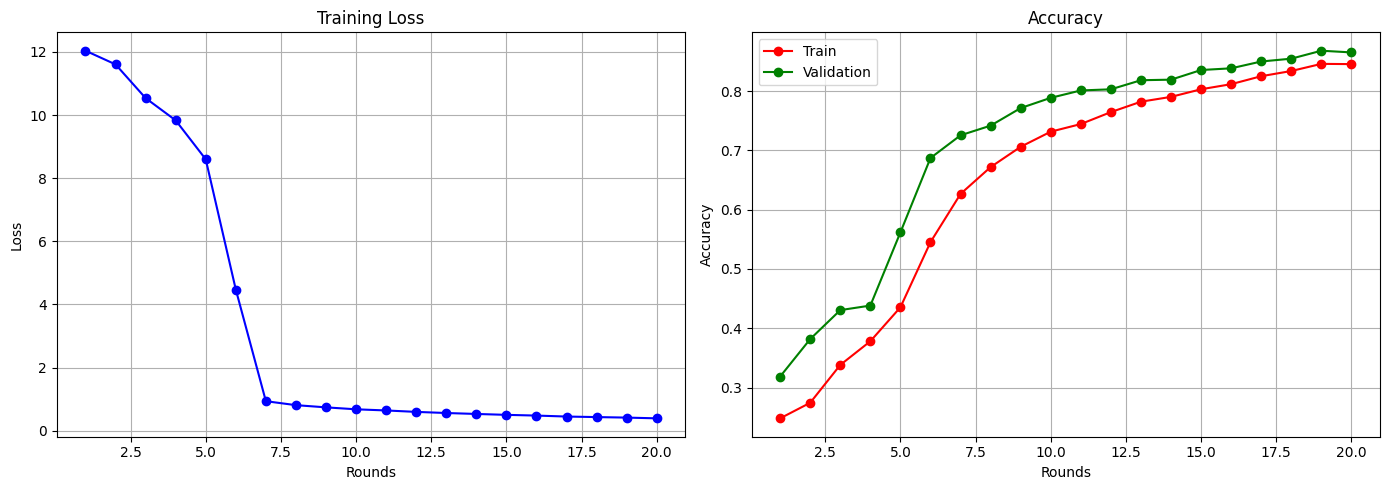

In [25]:
# Plotting function
def plot_metrics(history):
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['round'], history['train_loss'], 'b-o')
    plt.title('Training Loss')
    plt.xlabel('Rounds')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history['round'], history['train_acc'], 'r-o', label='Train')
    plt.plot(history['round'], history['val_acc'], 'g-o', label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Rounds')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/BrnTmr/training metrics.png')
    plt.show()

# Generate plots
plot_metrics(training_history)

Saving the model

In [26]:
# Final model evaluation and saving
final_model = create_cnn_model()
final_weights = training_process.get_model_weights(train_state)
final_model.set_weights(final_weights.non_trainable + final_weights.trainable)
final_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# Save model in TensorFlow format
model_save_path = '/content/drive/MyDrive/BrnTmr/final model'
final_model.save(model_save_path, save_format='tf')
print(f'Model saved to {model_save_path}')

Model saved to /content/drive/MyDrive/BrnTmr/final model
